In [9]:
from astropy.cosmology import Planck15
from astropy import constants
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [12]:
f_pi_design, pi_design = np.loadtxt("data/PICurve_Design.dat", unpack=True)
f_pi_o1o2,_,  pi_o1o2 = np.loadtxt("data/PICurve_O1O2.dat", unpack=True)


In [2]:
z_arr = np.logspace(-3, np.log10(20), 100000)
lookback_time_to_z = interp1d(Planck15.lookback_time(z_arr).value, z_arr)

def Rstar_z(z):
    """
    The star formation rate as a function of redshift
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 24 / u.yr / u.Gpc ** 3
    numerator = nu * a * np.exp(b * (z - zm))
    denominator = a - b + b * np.exp(a * (z - zm))
    return numerator / denominator

def Rstar_tL(lookback_time):
    """
    The star formation rate as a function of lookback time
    """
    
    a, b, zm, nu = 2.8, 2.46, 1.72, .146e9
    numerator = nu * a * np.exp(b * (z - zm))
    denominator = a - b + b * np.exp(a * (z - zm))
    return numerator / denominator

In [6]:
def dEdf(freq, factor):
    numerator =  np.pi ** (2/3) * constants.G ** (2/3) * factor * freq ** (-1/3)
    denominator = 3  * constants.c ** 2
    return numerator / denominator

def omega_GW_without_time_delay(f_arr, chirp_mass_distribution,
                               extra_args=dict()):
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        print("Using Delta Function distribution")
        factor = extra_args["val"] ** (5/3) * u.M_sun ** (5/3)
        print(factor)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
        print(factor)
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck15.critical_density0 * Planck15.H0) 
        integrand = Rstar_z(z) / (1 + z) * Planck15.inv_efunc(z) * dEdf(freq / (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result

def gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp((x - mu) ** 2  / 2 / sigma **2)

def flat(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / (maximum - minimum)
    return y

27it [00:00, 269.92it/s]

Using Delta Function distribution
289.646815381689 solMass(5/3)


190it [00:00, 298.98it/s]
42it [00:00, 416.27it/s]

Using Delta Function distribution
2154.4346900318847 solMass(5/3)


190it [00:00, 410.11it/s]


(10, 200)

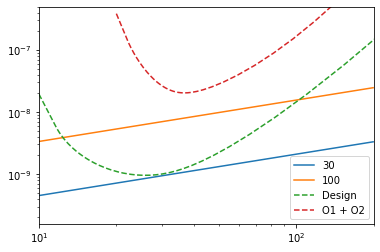

In [25]:
f_arr = np.arange(10, 200, 1)
for chirp_mass in [30, 100]:
    omega = omega_GW_without_time_delay(f_arr, "delta_function", extra_args=dict(val=chirp_mass),)
    plt.loglog(f_arr, omega, label=chirp_mass)
    
plt.plot(f_pi_design, pi_design, label="Design", ls="--")
plt.plot(f_pi_o1o2, pi_o1o2, label="O1 + O2", ls="--")
plt.legend()
plt.ylim(ymax=5e-7)
plt.xlim(10, 200)

# BACKUP

In [ ]:
def omega_GW_without_time_delay(f_arr, dEdf_function,
                               extra_args=dict()):
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck15.critical_density0 * Planck15.H0) 
        integrand = Rstar_z(z) / (1 + z) * Planck15.inv_efunc(z) * dEdf_function(freq / (1 + z), z, **extra_args) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result


def dEdf_single_chirp_mass(freq, z, val=30):
    freq = freq
    chirp_mass = val * u.M_sun
    numerator =  np.pi ** (2/3) * constants.G ** (2/3) * chirp_mass ** (5/3) * freq ** (-1/3)
    denominator = 3  * constants.c ** 2
    return numerator / denominator

In [ ]:
f_arr = np.arange(20, 1000, 1)
for chirp_mass in [10]:
    omega = omega_GW_without_time_delay(f_arr, dEdf_single_chirp_mass, extra_args=dict(val=chirp_mass))
    plt.loglog(f_arr, omega, ".")